In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from mlxtend.plotting import plot_decision_regions
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [ ]:
df = pd.read_csv('cupcakes.csv')   # change path as needed
df.head()

,Type,Flour,Milk,Sugar,Butter,Egg,Baking Powder,Vanilla,Salt
0,Muffin,55,28,3,7,5,2,0,0
1,Muffin,47,24,12,6,9,1,0,0
2,Muffin,47,23,18,6,4,1,0,0
3,Muffin,45,11,17,17,8,1,0,0
4,Muffin,50,25,12,6,5,2,1,0


In [ ]:
df.shape

(20, 4)

In [ ]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['Type'])
df['label']

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
Name: label, dtype: int32

In [ ]:
df = df[["Flour", "Sugar", "label"]]
df.columns = ["X1", "X2", "label"]

In [ ]:
df["weights"] = 1 / df.shape[0]
display(df.head())

C:\Users\91978\AppData\Local\Temp\ipykernel_33024\8371175.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["weights"] = 1 / df.shape[0]


,X1,X2,label,weights
0,55,3,1,0.05
1,47,12,1,0.05
2,47,18,1,0.05
3,45,17,1,0.05
4,50,12,1,0.05


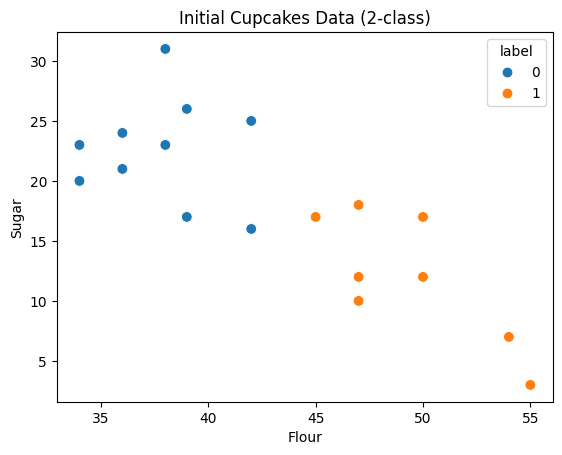

In [ ]:
sns.scatterplot(x="X1", y="X2", hue="label", data=df, s=60)
plt.title("Initial Cupcakes Data (2-class)")
plt.xlabel("Flour")
plt.ylabel("Sugar")
plt.show()

In [ ]:
x = df[["X1", "X2"]].values
y = df["label"].values

![image.png](attachment:3f6f21a5-1007-44e9-a93d-941eaf213a32.png)

np.clip(array, min_value, max_value)
Any value below min_value becomes min_value.

Any value above max_value becomes max_value.

Values in between stay unchanged.

In [ ]:
def calculate_model_weight(error):
    eps = 1e-10
    error = np.clip(error, eps, 1 - eps)
    return 0.5 * np.log((1 - error) / error)




![image.png](attachment:3a5f02a6-bbbe-4cd2-9949-96bfec6faf01.png)

In [ ]:
def update_row_weights(row, alpha):
    if row["label"] == row["y_pred"]:
        return row["weights"] * np.exp(-alpha)
    else:
        return row["weights"] * np.exp(alpha)

def create_new_dataset(df):
    indices = []
    n = df.shape[0]
    for _ in range(n):
        a = np.random.random()
        for idx, row in df.iterrows():
            if row["cumsum_lower"] < a <= row["cumsum_upper"]:
                indices.append(idx)
                break
    if len(indices) == 0:
        indices = np.random.choice(df.index, size=n, replace=True).tolist()
    return indices


![image.png](attachment:badaee34-b915-4153-92b9-7a9dd8c4b6f1.png)

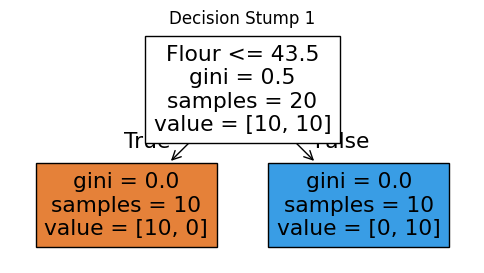

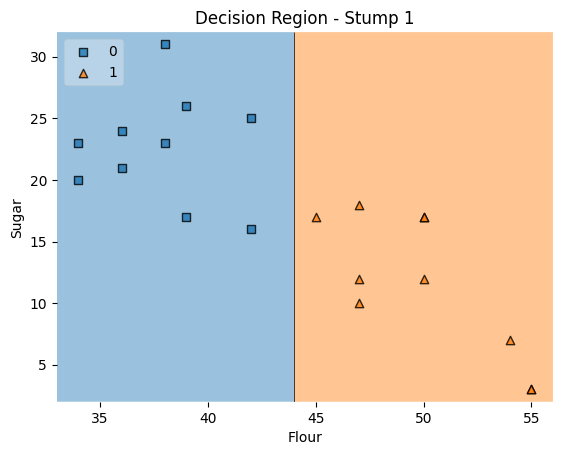

In [ ]:
#Step 2: Train First Decision Stump
dt1 = DecisionTreeClassifier(max_depth=1)
dt1.fit(x, y)

plt.figure(figsize=(6,3))
plot_tree(dt1, filled=True, feature_names=["Flour", "Sugar"])
plt.title("Decision Stump 1")
plt.show()

plot_decision_regions(x, y, clf=dt1, legend=2)
plt.title("Decision Region - Stump 1")
plt.xlabel("Flour")
plt.ylabel("Sugar")
plt.show()


In [ ]:
# Predictions & weighted error
df["y_pred"] = dt1.predict(x)
error = np.sum(df["weights"] * (df["label"] != df["y_pred"]))
alpha1 = calculate_model_weight(error)
print(f"Model 1 alpha: {alpha1:.3f}")

# Update and normalize weights
df["updated_weights"] = df.apply(lambda row: update_row_weights(row, alpha1), axis=1)
df["normalized_weights"] = df["updated_weights"] / df["updated_weights"].sum()

# Compute cumulative bounds
df["cumsum_upper"] = np.cumsum(df["normalized_weights"])
df["cumsum_lower"] = df["cumsum_upper"] - df["normalized_weights"]
display(df[["X1", "X2", "label", "weights", "y_pred", "normalized_weights"]])

Model 1 alpha: 11.513


,X1,X2,label,weights,y_pred,normalized_weights
0,55,3,1,0.05,1,0.05
1,47,12,1,0.05,1,0.05
2,47,18,1,0.05,1,0.05
3,45,17,1,0.05,1,0.05
4,50,12,1,0.05,1,0.05
5,55,3,1,0.05,1,0.05
6,54,7,1,0.05,1,0.05
7,47,10,1,0.05,1,0.05
8,50,17,1,0.05,1,0.05
9,50,17,1,0.05,1,0.05


In [ ]:
# Resample for next stump
index_values = create_new_dataset(df)
print("Resampled indices (1st):", index_values)
second_df = df.loc[index_values, ["X1", "X2", "label", "normalized_weights"]].reset_index(drop=True)


Resampled indices (1st): [1, 14, 13, 7, 4, 16, 14, 19, 8, 2, 12, 18, 4, 19, 13, 16, 0, 5, 18, 9]


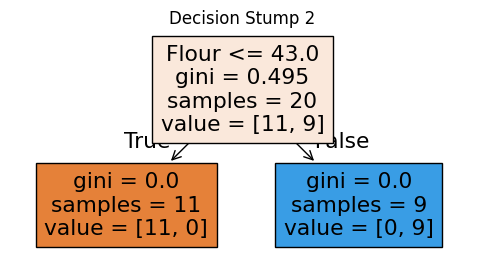

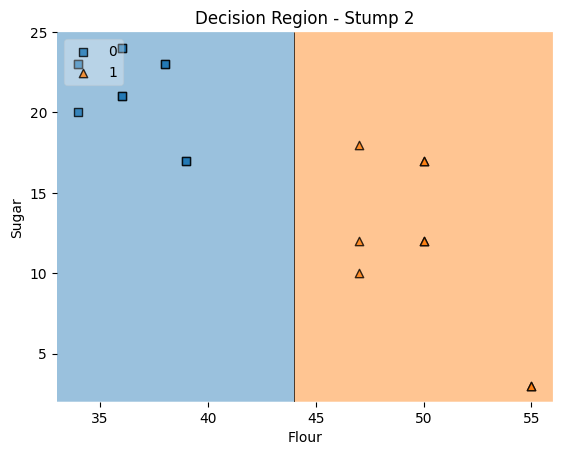

In [ ]:
# ======================================
# Step 3: Train Second Decision Stump
# ======================================
x2 = second_df[["X1", "X2"]].values
y2 = second_df["label"].values
dt2 = DecisionTreeClassifier(max_depth=1)
dt2.fit(x2, y2)

plt.figure(figsize=(6,3))
plot_tree(dt2, filled=True, feature_names=["Flour", "Sugar"])
plt.title("Decision Stump 2")
plt.show()

plot_decision_regions(x2, y2, clf=dt2, legend=2)
plt.title("Decision Region - Stump 2")
plt.xlabel("Flour")
plt.ylabel("Sugar")
plt.show()

In [ ]:
second_df["y_pred"] = dt2.predict(x2)
error2 = np.sum(second_df["normalized_weights"] * (second_df["label"] != second_df["y_pred"]))
alpha2 = calculate_model_weight(error2)
print(f"Model 2 alpha: {alpha2:.3f}")


Model 2 alpha: 11.513


In [ ]:
# Update weights again
def update_row_weights_2(row, alpha=alpha2):
    if row["label"] == row["y_pred"]:
        return row["normalized_weights"] * np.exp(-alpha)
    else:
        return row["normalized_weights"] * np.exp(alpha)

second_df["updated_weights"] = second_df.apply(update_row_weights_2, axis=1)
second_df["normalized_weights"] = second_df["updated_weights"] / second_df["updated_weights"].sum()
second_df["cumsum_upper"] = np.cumsum(second_df["normalized_weights"])
second_df["cumsum_lower"] = second_df["cumsum_upper"] - second_df["normalized_weights"]

index_values2 = create_new_dataset(second_df)
print("Resampled indices (2nd):", index_values2)
third_df = second_df.loc[index_values2, ["X1", "X2", "label", "normalized_weights"]].reset_index(drop=True)



Resampled indices (2nd): [18, 1, 1, 2, 16, 13, 7, 11, 15, 2, 16, 16, 0, 9, 5, 6, 18, 15, 8, 11]


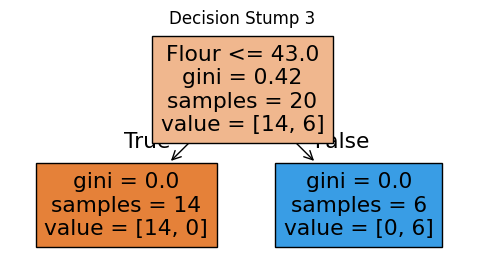

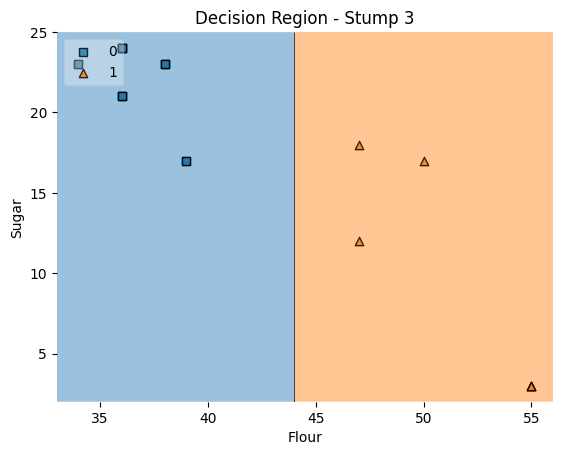

In [ ]:
# ======================================
# Step 4: Train Third Decision Stump
# ======================================
x3 = third_df[["X1", "X2"]].values
y3 = third_df["label"].values
dt3 = DecisionTreeClassifier(max_depth=1)
dt3.fit(x3, y3)

plt.figure(figsize=(6,3))
plot_tree(dt3, filled=True, feature_names=["Flour", "Sugar"])
plt.title("Decision Stump 3")
plt.show()

plot_decision_regions(x3, y3, clf=dt3, legend=2)
plt.title("Decision Region - Stump 3")
plt.xlabel("Flour")
plt.ylabel("Sugar")
plt.show()

In [ ]:
third_df["y_pred"] = dt3.predict(x3)
error3 = np.sum(third_df["normalized_weights"] * (third_df["label"] != third_df["y_pred"]))
alpha3 = calculate_model_weight(error3)
print(f"Model 3 alpha: {alpha3:.3f}")

Model 3 alpha: 11.513



Final Model Weights (alphas):
Alpha1 = 11.513, Alpha2 = 11.513, Alpha3 = 11.513


Text(0, 0.5, 'Sugar')

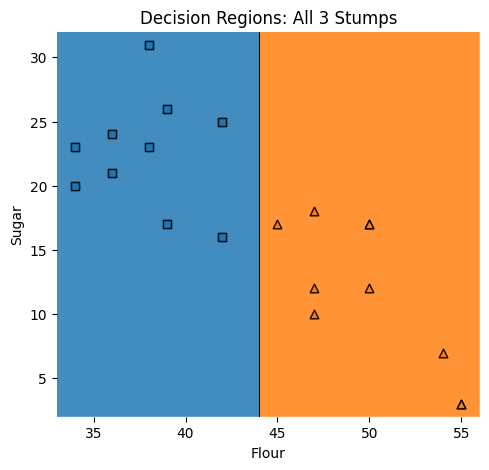

In [ ]:
# Step 5: Combined Visualization
# ======================================
print("\nFinal Model Weights (alphas):")
print(f"Alpha1 = {alpha1:.3f}, Alpha2 = {alpha2:.3f}, Alpha3 = {alpha3:.3f}")

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plot_decision_regions(x, y, clf=dt1, legend=0)
plot_decision_regions(x, y, clf=dt2, legend=0)
plot_decision_regions(x, y, clf=dt3, legend=0)
plt.title("Decision Regions: All 3 Stumps")
plt.xlabel("Flour")
plt.ylabel("Sugar")

C:\Users\91978\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


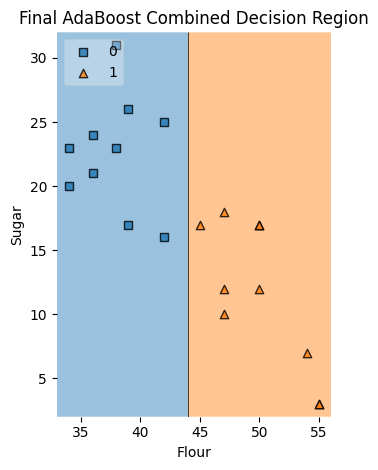

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada_final = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=3,
    algorithm="SAMME"
)
ada_final.fit(x, y)

plt.subplot(1,2,2)
plot_decision_regions(x, y, clf=ada_final, legend=2)
plt.title("Final AdaBoost Combined Decision Region")
plt.xlabel("Flour")
plt.ylabel("Sugar")
plt.tight_layout()
plt.show()

C:\Users\91978\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


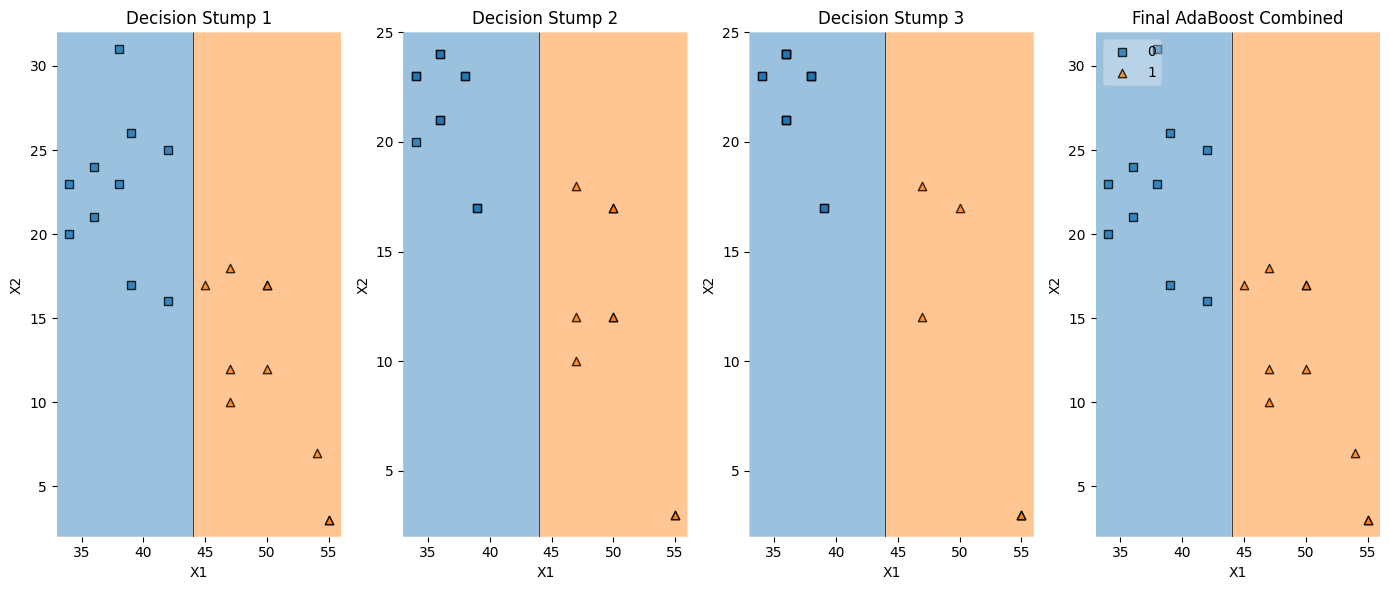

In [ ]:
# ======================================
# Step 6: Visualize All Stumps Together
# ======================================
from sklearn.ensemble import AdaBoostClassifier

plt.figure(figsize=(14, 6))

# --- Subplot 1: Decision Stump 1 ---
plt.subplot(1, 4, 1)
plot_decision_regions(x, y, clf=dt1, legend=0)
plt.title("Decision Stump 1")
plt.xlabel("X1")
plt.ylabel("X2")

# --- Subplot 2: Decision Stump 2 ---
plt.subplot(1, 4, 2)
plot_decision_regions(x2, y2, clf=dt2, legend=0)
plt.title("Decision Stump 2")
plt.xlabel("X1")
plt.ylabel("X2")

# --- Subplot 3: Decision Stump 3 ---
plt.subplot(1, 4, 3)
plot_decision_regions(x3, y3, clf=dt3, legend=0)
plt.title("Decision Stump 3")
plt.xlabel("X1")
plt.ylabel("X2")

# --- Subplot 4: Final Combined AdaBoost ---
ada_final = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=3,
    algorithm="SAMME"
)
ada_final.fit(x, y)

plt.subplot(1, 4, 4)
plot_decision_regions(x, y, clf=ada_final, legend=2)
plt.title("Final AdaBoost Combined")
plt.xlabel("X1")
plt.ylabel("X2")

plt.tight_layout()
plt.show()

In [ ]:
# ---------------------------------
# 🧁 Muffin vs Cupcake using AdaBoost + All Decision Stumps Visualization
# ---------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import AdaBoostClassifier



In [ ]:
df = pd.read_csv('cupcakes.csv')   # change path as needed
df.head()

,Type,Flour,Milk,Sugar,Butter,Egg,Baking Powder,Vanilla,Salt
0,Muffin,55,28,3,7,5,2,0,0
1,Muffin,47,24,12,6,9,1,0,0
2,Muffin,47,23,18,6,4,1,0,0
3,Muffin,45,11,17,17,8,1,0,0
4,Muffin,50,25,12,6,5,2,1,0


In [ ]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['Type'])
df['label']

0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
19    0
Name: label, dtype: int32

In [ ]:


df['Label'] = df['Type'].map({'Muffin': 0, 'Cupcake': 1})



In [ ]:
X = df[['Sugar', 'Flour']]
y = df['Label']



In [ ]:
# 2️⃣ Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)



In [ ]:
# 3️⃣ Create AdaBoost model with Decision Stumps
base_tree = DecisionTreeClassifier(max_depth=1)
ada = AdaBoostClassifier(
    estimator=base_tree,
    n_estimators=3,        # use 3 stumps for visualization
    learning_rate=1.0,
    random_state=42
)


In [ ]:

# 4️⃣ Train model
ada.fit(X_train, y_train)




,estimator,DecisionTreeC...r(max_depth=1)
,n_estimators,3
,learning_rate,1.0
,algorithm,'deprecated'
,random_state,42
,criterion,'gini'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


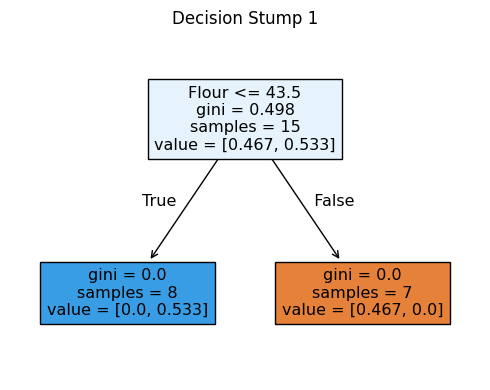

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Determine how many stumps (weak learners)
n_stumps = len(ada.estimators_)

# Create subplots dynamically
fig, axes = plt.subplots(1, n_stumps, figsize=(5 * n_stumps, 4))

# Handle case when only one stump exists
if n_stumps == 1:
    axes = [axes]

# Plot each decision stump on its corresponding axis
for i, tree in enumerate(ada.estimators_):
    plot_tree(tree, feature_names=['Sugar', 'Flour'], filled=True, ax=axes[i])
    axes[i].set_title(f"Decision Stump {i + 1}")

plt.tight_layout()
plt.show()


In [ ]:
# 6️⃣ Plot final decision boundary
x_min, x_max = X['Sugar'].min() - 1, X['Sugar'].max() + 1
y_min, y_max = X['Flour'].min() - 1, X['Flour'].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))



In [ ]:
Z = ada.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)



C:\Users\91978\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


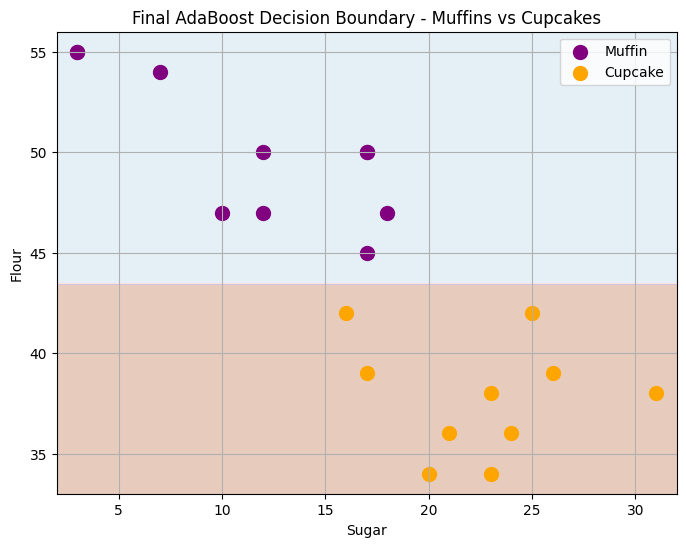

In [ ]:
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
plt.scatter(df[df['Type']=='Muffin']['Sugar'],
            df[df['Type']=='Muffin']['Flour'],
            color='purple', label='Muffin', s=100)
plt.scatter(df[df['Type']=='Cupcake']['Sugar'],
            df[df['Type']=='Cupcake']['Flour'],
            color='orange', label='Cupcake', s=100)

plt.xlabel('Sugar')
plt.ylabel('Flour')
plt.title('Final AdaBoost Decision Boundary - Muffins vs Cupcakes')
plt.legend()
plt.grid(True)
plt.show()

# simple Adaboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from mlxtend.plotting import plot_decision_regions

In [ ]:
df = pd.read_csv('cupcakes.csv')   # change path as needed
df.head()

,Type,Flour,Milk,Sugar,Butter,Egg,Baking Powder,Vanilla,Salt
0,Muffin,55,28,3,7,5,2,0,0
1,Muffin,47,24,12,6,9,1,0,0
2,Muffin,47,23,18,6,4,1,0,0
3,Muffin,45,11,17,17,8,1,0,0
4,Muffin,50,25,12,6,5,2,1,0


In [ ]:
# Convert to numeric labels
data['Label'] = data['Type'].map({'Muffin': 0, 'Cupcake': 1})
X = data[['Sugar', 'Flour']].values
y = data['Label'].values

In [ ]:

base_tree = DecisionTreeClassifier(max_depth=1, random_state=42)

ada = AdaBoostClassifier(
    estimator=base_tree,
    n_estimators=3,
    learning_rate=1.0,
    random_state=42
)


Number of trained stumps: 3


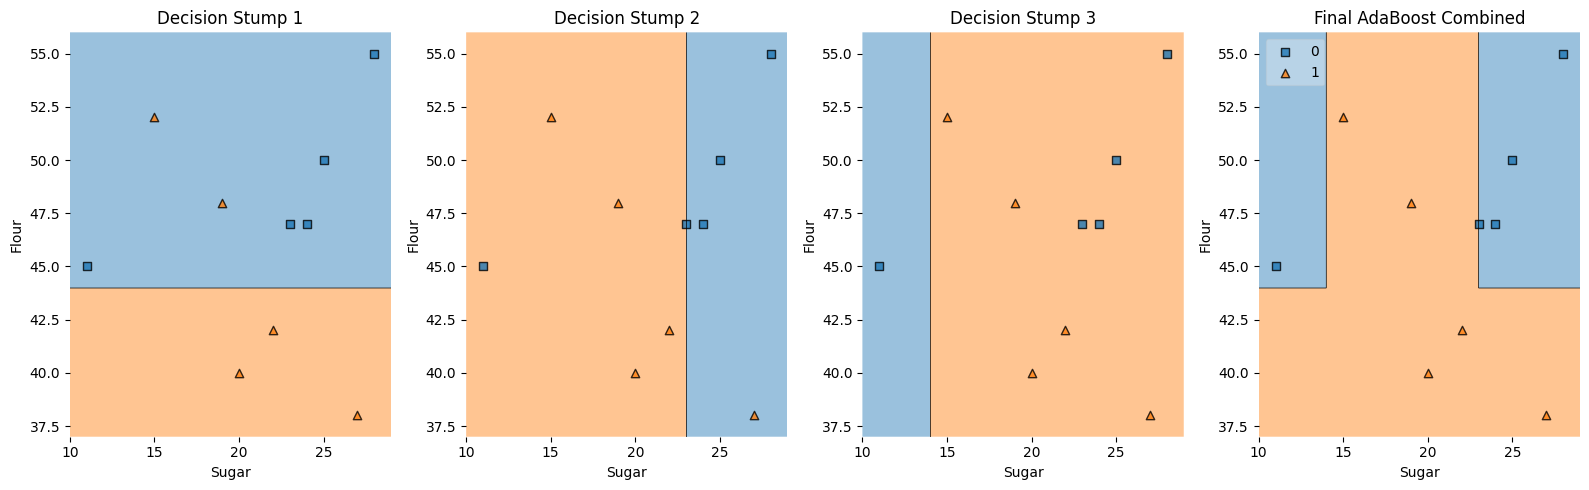

In [ ]:
ada.fit(X, y)
print("Number of trained stumps:", len(ada.estimators_))


plt.figure(figsize=(16, 5))
estimators = ada.estimators_

# Decision Stump 1
plt.subplot(1, 4, 1)
plot_decision_regions(X, y, clf=estimators[0], legend=0)
plt.title("Decision Stump 1")
plt.xlabel("Sugar")
plt.ylabel("Flour")

# Decision Stump 2
if len(estimators) > 1:
    plt.subplot(1, 4, 2)
    plot_decision_regions(X, y, clf=estimators[1], legend=0)
    plt.title("Decision Stump 2")
    plt.xlabel("Sugar")
    plt.ylabel("Flour")

# Decision Stump 3
if len(estimators) > 2:
    plt.subplot(1, 4, 3)
    plot_decision_regions(X, y, clf=estimators[2], legend=0)
    plt.title("Decision Stump 3")
    plt.xlabel("Sugar")
    plt.ylabel("Flour")

# Final Combined AdaBoost
plt.subplot(1, 4, 4)
plot_decision_regions(X, y, clf=ada, legend=2)
plt.title("Final AdaBoost Combined")
plt.xlabel("Sugar")
plt.ylabel("Flour")

plt.tight_layout()
plt.show()



In [ ]:
print("\nAlpha (Model Weights):", ada.estimator_weights_)
print("Errors of stumps:", ada.estimator_errors_)


Alpha (Model Weights): [1.38629436 1.94591015 1.79175947]
Errors of stumps: [0.2        0.125      0.14285714]


# New Data

In [ ]:
sample = np.array([[22, 46]])  # (Sugar, Flour)
pred = ada.predict(sample)[0]
label = "Cupcake" if pred == 1 else "Muffin"
print(f"\nNew recipe with Sugar={sample[0][0]}, Flour={sample[0][1]} → Predicted: {label}")


New recipe with Sugar=22, Flour=46 → Predicted: Cupcake
